In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

In [2]:
dowhy.__version__

'0.8'

In [3]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

# Chapter 07

In this chapter we focus on the full four-steps causal inference process. First, we introduce DoWhy and EconML libraries. Next, we discuss and exercise how to encode causal information in a form of a graph that is understandable to DoWhy. Next, we demonstrate how to find applicable estimands for a problem at hand. Then, we compute causal effect estimates using DoWhy and estimators provided in EconML. To understand how good our estimates are, we perform a series of refutal tests. Finally, we run a full (and more complex) causal process using DoWhy and EconML.

## Causal models with DoWhy & EconML

### Generate the data

In [4]:
# First, we'll build a structural causal model (SCM)
class GPSMemorySCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)
        
        if treatment_value:
            gps = np.array([treatment_value]*sample_size)
        else:
            gps = u_x + 0.7*u
            
        hippocampus = -0.6*gps + 0.25*u_z
        memory = 0.7*hippocampus + 0.25*u
        
        return gps, hippocampus, memory
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [5]:
# Instantiate the SCM
scm = GPSMemorySCM()

# Generate observational data
gps_obs, hippocampus_obs, memory_obs = scm.sample(1000)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([gps_obs, hippocampus_obs, memory_obs]).T, columns=['X', 'Z', 'Y'])

In [6]:
df

,X,Z,Y
0,4.913517,-3.336259,-1.062827
1,6.554867,-4.153368,-1.067321
2,8.884924,-4.715010,-1.892951
3,13.985812,-9.348827,-5.768484
4,1.552113,-1.295731,-0.365418
...,...,...,...
995,4.449338,-2.199691,-0.586440
996,5.257915,-2.793845,-1.281048
997,0.729923,-0.789898,-0.320348
998,2.311561,-0.406512,-0.272665


### Step 1: Modeling the problem

#### Step 1.1 - Define the graph - `GML`

In [7]:
# Create the graph describing the causal structure
gml_graph = """
graph [
    directed 1
    
    node [
        id "X" 
        label "X"
    ]    
    node [
        id "Z"
        label "Z"
    ]
    node [
        id "Y"
        label "Y"
    ]
    node [
        id "U"
        label "U"
    ]
    
    edge [
        source "X"
        target "Z"
    ]
    edge [
        source "Z"
        target "Y"
    ]
    edge [
        source "U"
        target "X"
    ]
    edge [
        source "U"
        target "Y"
    ]
]
"""

#### Step 1.2 - define the DoWhy model

In [8]:
# With graph
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_graph
)

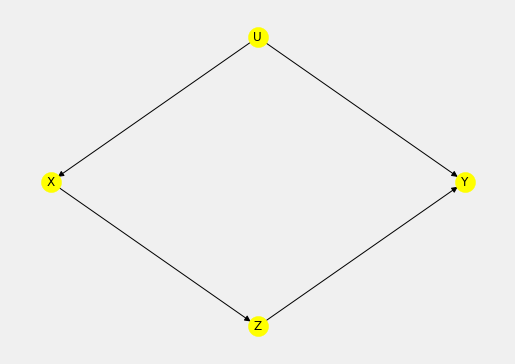

In [9]:
model.view_model()

### Step 2: Identify the estimand

In [10]:
estimand = model.identify_effect()
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)



### Step 3: Estimate the causal effect

#### Example 1 - Linear Regression

In [11]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='frontdoor.two_stage_regression')

print(f'Estimate of causal effect (linear regression): {estimate.value}')

two_stage_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
Estimate of causal effect (linear regression): -0.4101007729201311


### Step 4: Run refutation tests

In [12]:
refute_subset = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name="data_subset_refuter", 
    subset_fraction=0.4)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, '

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, '

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, '

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, '

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, '

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, '

In [13]:
print(refute_subset)

Refute: Use a subset of data
Estimated effect:-0.4101007729201311
New effect:-0.4094252079526228
p value:0.98



## Full example

### Data

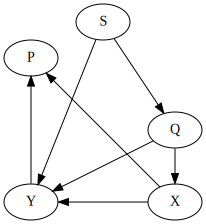

In [248]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['S', 'Q', 'X', 'Y', 'P']
positions = ['2,2.5!', '3,1!', '3,0!', '1, 0!', '1,2!', '1.7,0.9!']

edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_07_full_example')

graph

In [301]:
SAMPLE_SIZE = 1000

S = np.random.random(SAMPLE_SIZE)
Q = 0.2*S + 0.67*np.random.random(SAMPLE_SIZE)
X = 0.14*Q + 0.4*np.random.random(SAMPLE_SIZE)
Y = 0.7*X + 0.11*Q + 0.32*S + 0.24*np.random.random(SAMPLE_SIZE)
P = 0.43*X + 0.21*Y + 0.22*np.random.random(SAMPLE_SIZE)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])

In [302]:
# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

In [303]:
print(gml_string)

graph [directed 1
	node [id "S" label "S"]
	node [id "Q" label "Q"]
	node [id "X" label "X"]
	node [id "Y" label "Y"]
	node [id "P" label "P"]
	edge [source "S" target "Q"]
	edge [source "S" target "Y"]
	edge [source "Q" target "X"]
	edge [source "Q" target "Y"]
	edge [source "X" target "P"]
	edge [source "Y" target "P"]
	edge [source "X" target "Y"]
]


In [291]:
# Instantiate the CausalModel 
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_string
)

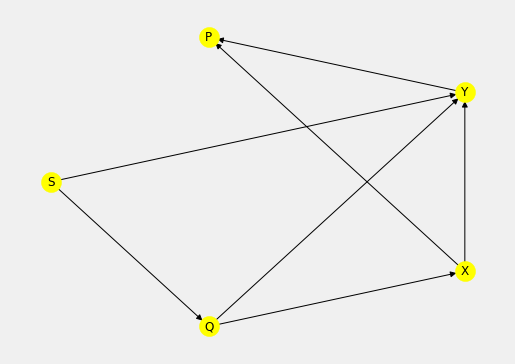

In [292]:
model.view_model()

In [293]:
# Get the estimand
estimand = model.identify_effect()
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Q])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Q,U) = P(Y|X,Q)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [318]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.DML',
    method_params={
        'init_params': {
            'model_y': GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            'model_final': LassoCV(fit_intercept=False),
        },
        'fit_params': {}}
)

print(f'Estimate of causal effect (DML): {estimate.value}')

Estimate of causal effect (DML): 0.6981455013596706


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [316]:
estimate_lr = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(f'Estimate of causal effect (linear regression): {estimate_lr.value}')

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
Estimate of causal effect (linear regression): 0.688147600764658


In [319]:
random_cause = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='random_common_cause'
)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

In [320]:
print(random_cause)

Refute: Add a random common cause
Estimated effect:0.6981455013596706
New effect:0.6691543110272069
p value:0.1399999999999999



In [321]:
placebo_refuter = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='placebo_treatment_refuter'
)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

In [322]:
print(placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:0.6981455013596706
New effect:0.0
p value:2.0



## GCM API

In [323]:
import networkx as nx
from dowhy import gcm

In [411]:
SAMPLE_SIZE = 1000

S = np.random.random(SAMPLE_SIZE)
Q = 0.2*S + 0.67*np.random.random(SAMPLE_SIZE)
X = 0.14*Q + 0.4*np.random.random(SAMPLE_SIZE)
Y = 0.7*X + 0.11*Q + 0.32*S + 0.24*np.random.random(SAMPLE_SIZE)
P = 0.43*X + 0.21*Y + 0.22*np.random.random(SAMPLE_SIZE)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])

In [413]:
edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']
graph_nx = nx.DiGraph([(edge[0], edge[1]) for edge in edges])

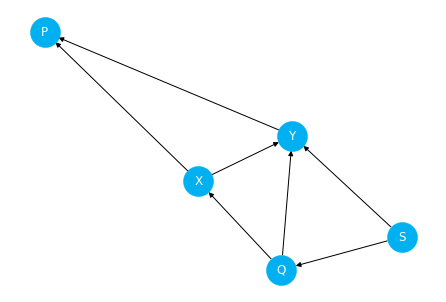

In [473]:
nx.draw(
    graph_nx, 
    with_labels=True, 
    node_size=900,
    font_color='white', 
    node_color=COLORS[0]
)

In [478]:
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

In [479]:
causal_model.set_causal_mechanism('S', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('X', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Y', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('P', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Q', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(causal_model, df)

Fitting causal mechanism of node P: 100%|███████████████████████████████████████████████| 5/5 [00:00<00:00, 416.72it/s]


In [480]:
gcm.arrow_strength(causal_model, 'Y')

{('Q', 'Y'): 0.0006632517083816319,
 ('S', 'Y'): 0.008486091866545382,
 ('X', 'Y'): 0.006866684034567223}

In [481]:
gcm.counterfactual_samples(
    causal_model,
    {'X': lambda x: .21},
    observed_data=pd.DataFrame(data=dict(X=[.5], Y=[.75], S=[.5], Q=[.4], P=[.34])))

,S,Q,X,Y,P
0,0.5,0.4,0.21,0.539558,0.169005
